In [1]:
import os

# Create TempData directory if it doesn't exist
temp_data_dir = './TempData'
if not os.path.exists(temp_data_dir):
    os.makedirs(temp_data_dir)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
train_data_dir = 'DataSet/Training'
test_data_dir = 'DataSet/Testing'

In [4]:
# Image parameters
img_height, img_width = 128, 128
batch_size = 16

In [5]:
# Create data generators for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 2297 images belonging to 4 classes.


In [7]:
# Load validation data
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 573 images belonging to 4 classes.


In [8]:
# Load test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 395 images belonging to 4 classes.


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [10]:
def build_mask_rcnn_with_transfer_learning(input_shape=(128, 128, 3), num_classes=4):
    # Load VGG16 without the top layers (fully connected layers)
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use layers from VGG16 as the encoder (backbone)
    block1_conv2 = vgg_base.get_layer('block1_conv2').output  # Shape (64, 64, 64)
    block2_conv2 = vgg_base.get_layer('block2_conv2').output  # Shape (32, 32, 128)
    block3_conv3 = vgg_base.get_layer('block3_conv3').output  # Shape (16, 16, 256)
    block4_conv3 = vgg_base.get_layer('block4_conv3').output  # Shape (8, 8, 512)

    # Mask head (decoder for segmentation)
    up1 = UpSampling2D((2, 2))(block4_conv3)  # Shape (16, 16, 512)
    merge1 = concatenate([up1, block3_conv3])  # Shape will be (16, 16, 768)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = Dropout(0.5)(conv4)

    up2 = UpSampling2D((2, 2))(conv4)  # Shape (32, 32, 256)
    merge2 = concatenate([up2, block2_conv2])  # Shape will be (32, 32, 384)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = Dropout(0.5)(conv5)

    up3 = UpSampling2D((2, 2))(conv5)  # Shape (64, 64, 128)
    merge3 = concatenate([up3, block1_conv2])  # Shape will be (64, 64, 192)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    conv6 = Dropout(0.5)(conv6)

    mask_output = Conv2D(1, (1, 1), activation='sigmoid')(conv6)

    # Classification head (for tumor type)
    flat = GlobalAveragePooling2D()(block4_conv3)  # Use block4_conv3 for classification
    class_output = Dense(num_classes, activation='softmax')(flat)

    model = Model(inputs=vgg_base.input, outputs=[class_output, mask_output])

    # Compile the model with Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=['categorical_crossentropy', 'binary_crossentropy'],
        metrics=['accuracy', 'accuracy']
    )

    return model

In [11]:
# Build the model with VGG16 as the feature extractor
model = build_mask_rcnn_with_transfer_learning(input_shape=(img_height, img_width, 3), num_classes=train_generator.num_classes)

In [12]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 128, 128, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 64, 64, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 64, 64, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 64, 64, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 32, 32, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 32, 32, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 16, 16, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 16, 16, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 32, 32, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 768)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 256)       │       1,769,72

 Total params: 9,960,261 (38.00 MB)

 Trainable params: 9,960,261 (38.00 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Callbacks
checkpoint = ModelCheckpoint('mask_rcnn_brain_tumor_VGG16.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(
    train_generator,
    epochs=10,  # Start with a lower number of epochs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - dense_accuracy: 0.4884 - loss: 1.1932 - val_dense_accuracy: 0.7400 - val_loss: 0.7590
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - dense_accuracy: 0.7985 - loss: 0.5285 - val_dense_accuracy: 0.7679 - val_loss: 0.6295
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - dense_accuracy: 0.8547 - loss: 0.3822 - val_dense_accuracy: 0.7400 - val_loss: 0.5917
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - dense_accuracy: 0.8803 - loss: 0.3214 - val_dense_accuracy: 0.8220 - val_loss: 0.4497
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - dense_accuracy: 0.9418 - loss: 0.1675 - val_dense_accuracy: 0.8290 - val_loss: 0.5140
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - dense_accuracy: 0.9654 - loss: 0.1114 - val_dense_accuracy: 0.8220 - val_loss: 0.6085
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - dense_accuracy: 0.9586 - loss: 0.1123 - val_dense_accuracy: 0.8185 - val_loss: 0.5961
Epoch 8/10
144/144 ━━━━━

In [15]:
print(history.history.keys())

dict_keys(['dense_accuracy', 'loss', 'val_dense_accuracy', 'val_loss'])


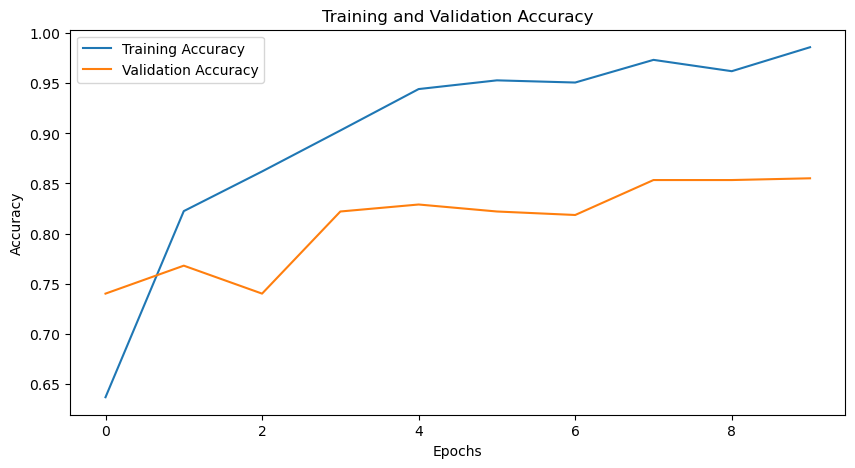

In [16]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['dense_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_dense_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

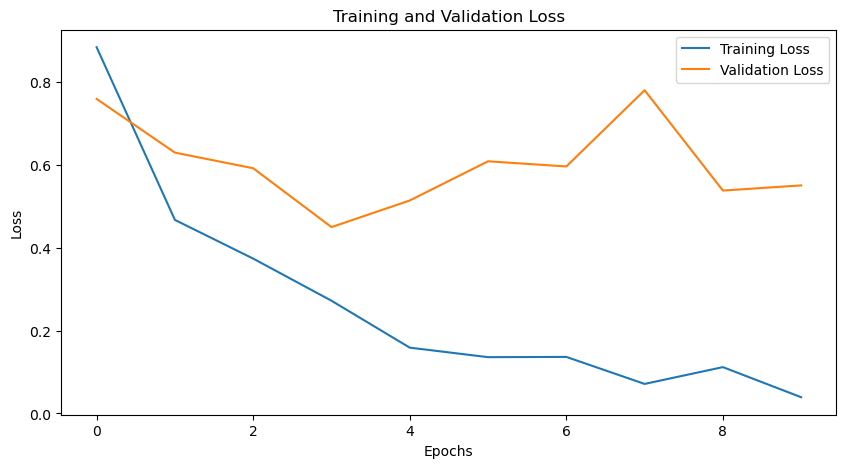

In [17]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()